In [351]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

INF = 9999.0
X, O, BLANK = 'X', 'O', ' '
N = 8
DOWN, UP = 1, -1

class State():
    
    def __init__(self, state=None, N=N):
        self.board = X*N + BLANK*(N-2)*N + O*N
        self.turn = X
        
        if state is not None:
            if type(state) is str:
                self.board = state
            else:
                self.board = state.board
                self.turn = state.turn 
            
    def move(self, move):
        ''' Moves players piece from Start to End index '''
        s, e = move
        player = self.board[s]
        # Remove piece
        self.board = self.board[:s] + BLANK + self.board[s+1:]
        # Place piece
        self.board = self.board[:e] + player + self.board[e+1:] 
        self.turn = X if self.turn == O else O
    
    def terminal_test(self):
        ''' Returns the victorious player if there is one '''
        # All pieces taken
        if X not in self.board:
            return -INF
        if O not in self.board:
            return INF
        
        # Check if either player has crossed board
        if X in self.board[N*(N-1):]:
            return INF
        if O in self.board[:N]:
            return -INF
        
        # Check if player cannot move, (return opponent as winner if so)
        if len(self.actions()) == 0:
            return INF if self.turn == O else -INF
        
        return None
            
    def __str__(self):        
        return (2*N+1)*'_' + ''.join(['\n|' + ''.join([e + '|' for e in self.board[i:i+N]]) + ' ' + \
                                     ''.join([str(j).rjust(3) for j in range(i, i+N)]) for i in range(0, N**2, N)])    
    
    def __repr__(self):
        return str(self)
    
    def actions(self):
        ''' Returns a list of possible actions for the player '''
        player   = X if self.turn == X else O
        opponent = O if self.turn == X else X
        direction = DOWN if player == X else UP
    
        # Find pieces
        lst = [i for i in range(N**2) if self.board[i] == player]

        actions = []
        for i in lst:
            # Check vertical is valid and free
            if (0 <= i+N*direction < N**2) and (self.board[i+N*direction] == BLANK):
                actions.append((i, i+N*direction))

            # Check diagonals are valid and taken by opposition
            # If not on left, check left
            new_i = i + N*direction - 1
            if (i%N != 0) and (0 <= new_i) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

            # If not on right, check right
            new_i = i + N*direction + 1
            if ((i+1)%N != 0) and (new_i < N**2) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

        return actions

In [355]:
α = 0.1
MAX_CHANGE = 0.1

def Φ(state):
    b = state.board
    
    def f(board, i, player):
        if player == O:
            i += N
        return 1 if board[i] == player else 0

    def pieces(state, player):
        return state.board.count(player)
    
    def row(state, r, player):
        add = 0
        if player == O:
            add = N
        return state.board[N*r+add:N*(r+1)+add].count(player)
    
    def n_actions(b, player):
        s = State(b)
        s.turn = player
        return len(s.actions())
    
    def end_in_sight(board, column, player):
        ''' Doesnt account for situation XOX '''
        direction = DOWN if player == X else UP
        opponent = O if player == X else X
        col = [board[i] for i in range(column, N**2, N)][::direction]
        if player in col:
            if opponent in col and col.index(player) < col.index(opponent):
                return 0
            return 1
        return -1

    def furthest_piece(board, column, player):
        direction = DOWN if player == X else UP
        col = [board[i] for i in range(column, N**2, N)][::-direction]
        if player in col:
            return N - col.index(player) - 1
        return -1

    def n_pieces_can_attack(state, player):
        ''' Number of players pieces that can attack opponent '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[0])

        return len(set(attacks))/N   

    def n_opp_can_be_attacked(state, player):
        ''' Number of opponents pieces that can be attacked '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[1])

        return len(set(attacks))/N
        
    return np.array([f(b, i, player) for player in [X, O] for i in range(N**2-N)] + 
                    [n_actions(b, player) for player in [X, O]] +
                    [pieces(state, player) for player in [X, O]] +
                    [row(state, r, player) for player in [X, O] for r in range(N-1)] +
                    [end_in_sight(b, c, player) for player in [X, O] for c in range(N)] +
                    [furthest_piece(b, c, player) for player in [X, O] for c in range(N)] +
                    [n_pieces_can_attack(state, player) for player in [X, O]] +
                    [n_opp_can_be_attacked(state, player) for player in [X, O]] +                    
                    [1.0])

def H(s, θ):
    h = np.dot(Φ(s), θ)
    if h < -INF:
        return -INF*0.99
    if h > +INF:
        return +INF*0.99
    return h

def tree_strap_train(θ, depth=3, printing=False):
    state = State()
    state.turn = np.random.choice([X, O])
    isMax = True if state.turn == X else False
    turn = 0
    random_turns = np.random.choice([0] + [2]*2 + [4]*4 + [6]*6 + [8]*8)
    
    print(state) if printing else None
    while state.terminal_test() is None:
        if turn < random_turns:
            state.move(state.actions()[np.random.choice([i for i in range(len(state.actions()))])])
        else:
            searched_states = []
            V = minimax(state, depth, isMax, θ, searched_states)

            Δθ = np.zeros(len(θ))
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for action in state.actions():
                result = State(state)
                result.move(action)
                actions.append((minimax(result, depth-1, not isMax, θ), action))

            print(actions) if printing else None
            if isMax:
                state.move(max(actions)[1])
            else:
                state.move(min(actions)[1])
                
        print(state) if printing else None 
        isMax = not isMax
        turn += 1
        
    return θ

def minimax(state, depth, isMax, θ, searched_states=None):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxEval = -INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            maxEval = max(maxEval, minimax(result, depth-1, not isMax, θ, searched_states))
        
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, maxEval, H(state, θ)))
        return maxEval
    
    else:
        minEval = +INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            minEval = min(minEval, minimax(result, depth-1, not isMax, θ, searched_states))
            
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, minEval, H(state, θ)))
        return minEval

In [356]:
#θ = np.array([np.random.uniform(0, 0.1) for _ in range(len(Φ(State())))])
θ = np.array([np.random.uniform(-10, 10) for _ in range(167)]) 
θs = [np.copy(θ)]
len(θ), len(Φ(State()))

(167, 167)

In [386]:
%%time
i = 0
while True:
    if i%1 == 0:
        print(i, end=' ')
    θ = tree_strap_train(θ, depth=4)
    θs.append(np.copy(θ))
    i += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 

KeyboardInterrupt: 

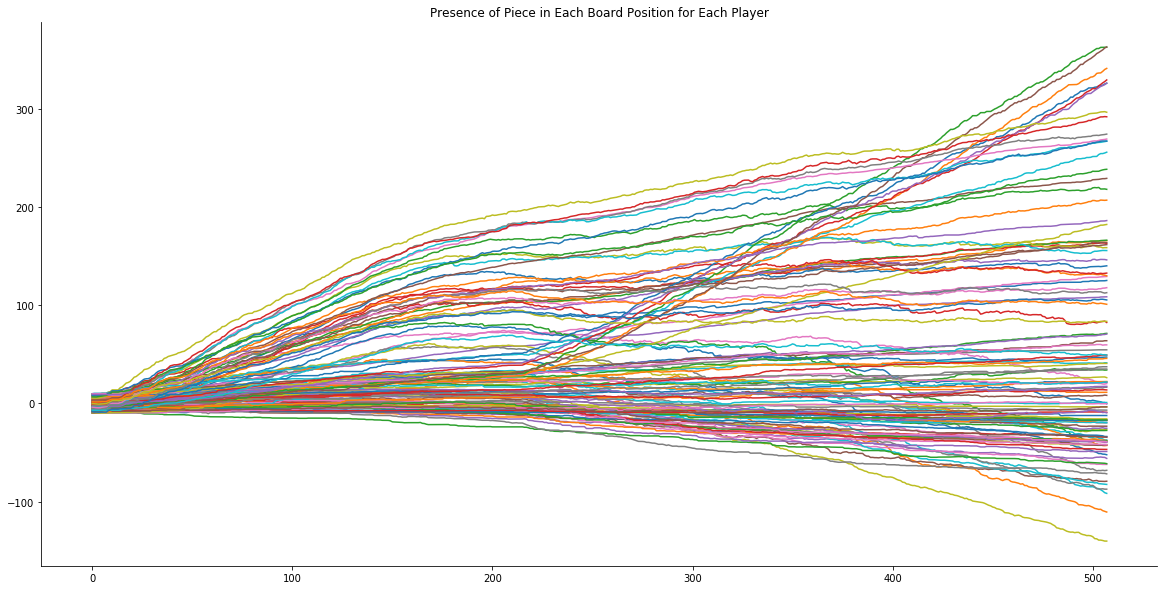

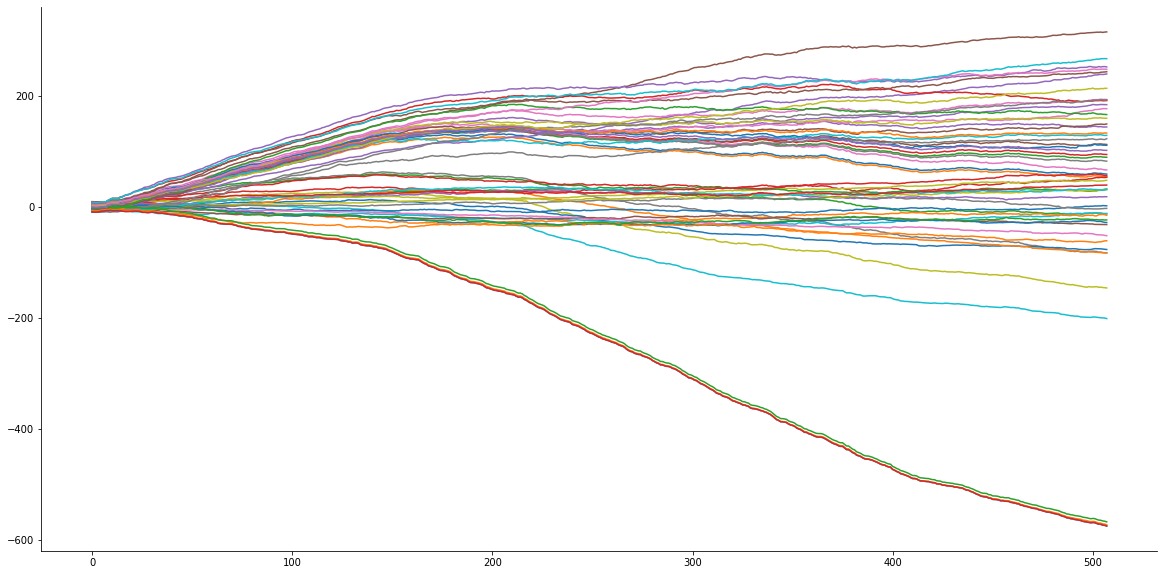

In [387]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(2*(N**2-N)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
ax.set_title('Presence of Piece in Each Board Position for Each Player')
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(2*(N**2-N), len(θ)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

In [379]:
TREESTRAP, RANDOM, HUMAN = 0, 1, 2
MOVE = {TREESTRAP: tree_strap_move, RANDOM: random_move}

def ab_pruning(state, depth, α, β, θ, isMax):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxV = -INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=False)
            maxV = max(maxV, value)
            α = max(α, value)
            if β <= α:
                break
        return maxV
    else:
        minV = +INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=True)
            minV = min(minV, value)
            β = min(β, value)
            if β <= α:
                break
        return minV

def random_move(state, θ=None, depth=None):
    if depth is not None or θ is not None:
        raise ValueError 
    actions = state.actions()
    return actions[np.random.choice([i for i in range(len(actions))])]

def tree_strap_move(state, θ, depth=5):
    if depth is None:
        raise ValueError 
    
    actions = []
    for action in state.actions():
        result = State(state)
        result.move(action)
        # If terminal state, no need to search
        if result.terminal_test() is not None:
            rn = result.terminal_test()
            actions.append((rn, action))
        else:
            isMax = True if result.turn == X else False
            actions.append((ab_pruning(result, depth, -INF, INF, θ, isMax=isMax), action))
    
    if state.turn == X:
        #print(actions)
        return max(actions)[1]
    return min(actions)[1]

def play(playerX=TREESTRAP, playerO=HUMAN, θX=None, θO=None, depthX=None, depthO=None, printing=False):
    if playerX == HUMAN:
        raise ValueError('You Monster!')
        
    s = State()
    s.turn = np.random.choice([X, O])
    
    def play_human(ai):
        print(s)
        while s.terminal_test() is None:
            if s.turn == O:
                print('\n', list(enumerate(s.actions())), sep='')
                i = int(input())
                s.move(s.actions()[i])
            else:
                s.move(MOVE[playerX](s, θX, depthX))

            print(s)
        print('\nGame Over!')
    
    if playerO == HUMAN:
        play_human(ai=playerX)
    else:
        print(s) if printing else None
        while s.terminal_test() is None:
            if s.turn == X:
                s.move(MOVE[playerX](s, θX, depthX))
            else:
                s.move(MOVE[playerO](s, θO, depthO))
            print(s) if printing else None
            
    θs.append(np.copy(θ))
    return int(s.terminal_test() > 0)

def validate(nGames=1, playerX=TREESTRAP, playerO=RANDOM, θX=θ, θO=None, depthX=3, depthO=None):
    wins = 0
    for _ in range(nGames):
        wins += play(playerX, playerO, θX, θO, depthX, depthO, printing=False)
    p = wins/nGames
    return p, (max(0, p - 1.96*np.sqrt(p*(1-p)/nGames)), min(1, p + 1.96*np.sqrt(p*(1-p)/nGames)))

#validate()

In [389]:
play(playerX=TREESTRAP, playerO=RANDOM, θX=θ, θO=None, depthX=4, depthO=None, printing=True)

_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X|X| |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X|X| |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47


_________________
|X|X| | | | | | |   0  1  2  3  4  5  6  7
| | |X|X|X|X| | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | |X| |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
|O| | |O| | | |O|  40 41 42 43 44 45 46 47
| |O|O| |O|O| |O|  48 49 50 51 52 53 54 55
| | | | | | | | |  56 57 58 59 60 61 62 63
_________________
|X|X| | | | | | |   0  1  2  3  4  5  6  7
| | |X|X|X|X| | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | |X| |  24 25 26 27 28 29 30 31
| | | |O| | | | |  32 33 34 35 36 37 38 39
|O| | | | | | |O|  40 41 42 43 44 45 46 47
| |O|O| |O|O| |O|  48 49 50 51 52 53 54 55
| | | | | | | | |  56 57 58 59 60 61 62 63
_________________
|X|X| | | | | | |   0  1  2  3  4  5  6  7
| | |X|X|X|X| | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | |O| | |X| |  32 33 34 35 36 37 38 39
|O| | | | | | |O|  40 41 42 43 44 45 46 47


1

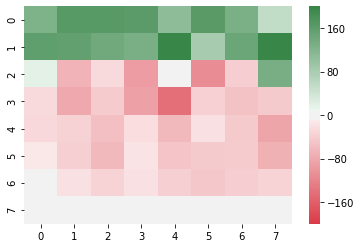

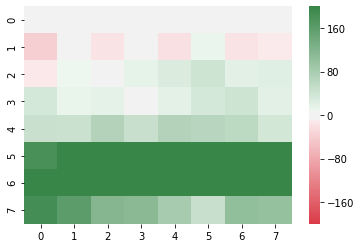

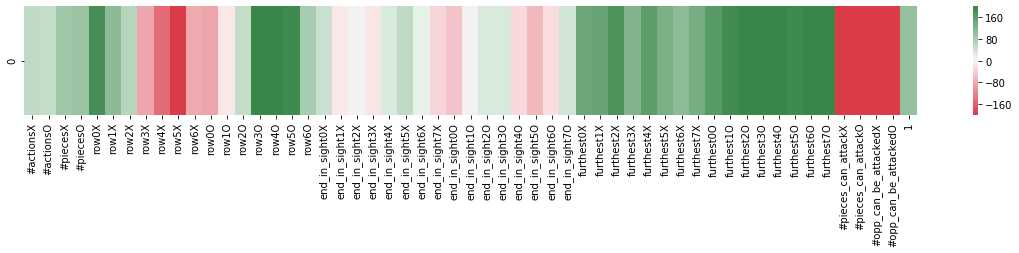

In [388]:
dataX = []
dataO = [np.array([0]*N)]
for i in range(0, N**2-N, N):
    dataX.append(θ[i:i+N])
dataX.append(np.array([0]*N))
    
for i in range(N**2-N, 2*(N**2-N), N):
    dataO.append(θ[i:i+N])
    
data = θ[2*(N**2-N):]
    
FACTOR = 200

cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(dataX, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()
sns.heatmap(dataO, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()

lbls = ['#actionsX', '#actionsO', '#piecesX', '#piecesO'] + [f'row{r}{p}' for p in [X, O] for r in range(N-1)] + \
       [f'end_in_sight{c}{p}' for p in [X, O] for c in range(N)] + [f'furthest{c}{p}' for p in [X, O] for c in range(N)] + \
       ['#pieces_can_attackX', '#pieces_can_attackO', '#opp_can_be_attackedX', '#opp_can_be_attackedO', '1']
fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([data], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()

In [ ]:
lbls = ['#actionsX', '#actionsO', '#piecesX', '#piecesO'] + ['row{r}{p}' for p in [X, O] for r in range(N-1)] + \
       ['end_in_sight{c}{p}' for p in [X, O] for c in range(N)] + ['furthest{c}{p}' for p in [X, O] for c in range(N)] + \
       ['#pieces_can_attackX', '#pieces_can_attackO', '#opp_can_be_attackedX', '#opp_can_be_attackedO', '1']


In [382]:
θ

array([ 104.47831654,  136.17809187,  141.0247146 ,  138.46527279,
         91.84299673,  137.2371217 ,  102.74917229,   46.9321978 ,
        167.22426739,  166.86483392,  135.29498698,  141.9434014 ,
        201.33610325,   99.57764881,  140.33099074,  195.49731915,
         68.51317256,   12.26862673,   13.81801503,  -13.62953028,
         46.76193598,  -23.33997719,   45.35404314,  143.08847005,
         -9.08324162,  -42.40408732,  -18.61328093,  -28.80607334,
        -52.89572275,    7.63553984,    7.24794595,   22.29104939,
        -14.78956901,  -25.43133497,  -36.47425565,  -11.60116932,
        -40.42545674,   -6.00038334,  -26.5025156 ,  -33.6943388 ,
         -8.09179137,  -31.9972457 ,  -44.2736465 ,   -9.47313468,
        -39.6271543 ,  -30.17868955,  -34.77596948,  -54.85631736,
         -1.07227223,  -17.55267621,  -19.27182102,  -14.62874851,
        -29.44631005,  -32.02995985,  -26.32696293,  -24.30652217,
        -29.40943271,   -3.68252392,  -10.05008011,    2.74231

In [390]:
α = 0.1
MAX_CHANGE = 0.5

def tree_strap_train(θ, depth=5, printing=False):
    state = State()
    state.turn = np.random.choice([X, O])
    
    print(state)
    while state.terminal_test() is None:
        if state.turn == O:
            print('\n', list(enumerate(state.actions())), sep='')
            i = int(input())
            state.move(state.actions()[i])

        else:
            searched_states = []
            V = minimax(state, depth, True, θ, searched_states)

            Δθ = np.zeros(len(θ))
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for action in state.actions():
                result = State(state)
                result.move(action)
                actions.append((minimax(result, depth-1, False, θ), action))

            print(actions) if printing else None
            state.move(max(actions)[1])
        print(state)
    print('Game Over!')
        
    return θ

θs.append(tree_strap_train(θ, 5, True))

_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63


KeyboardInterrupt: 

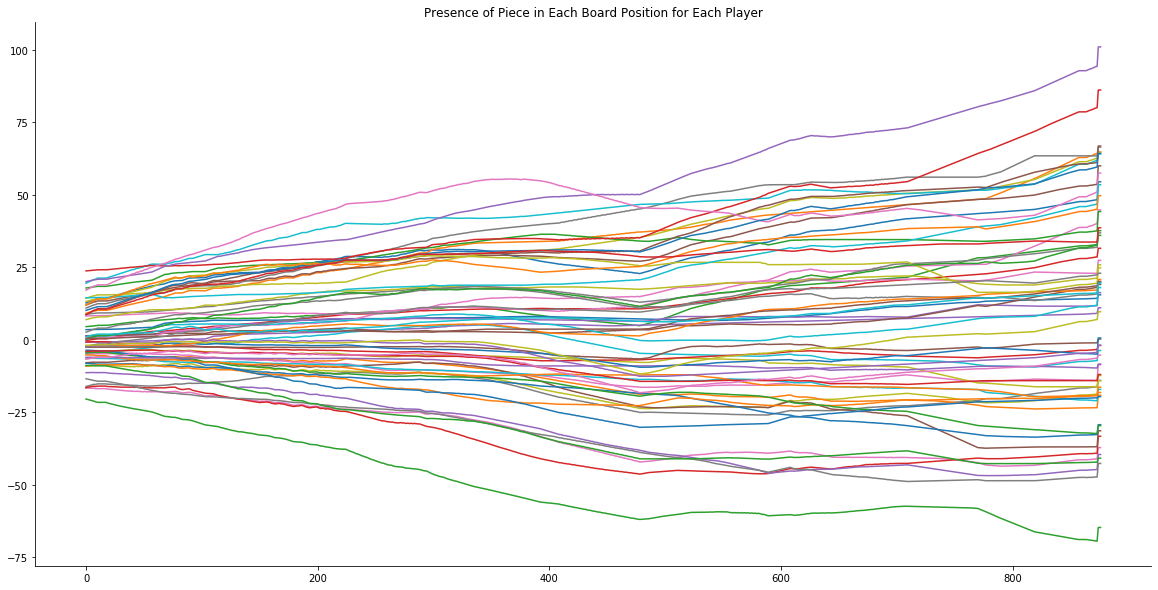

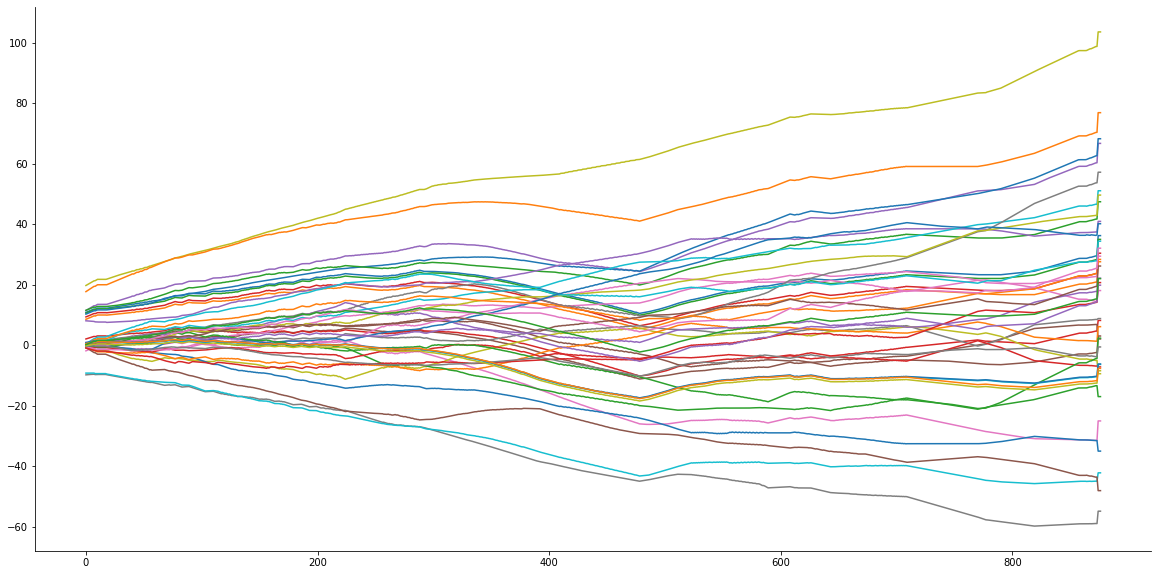

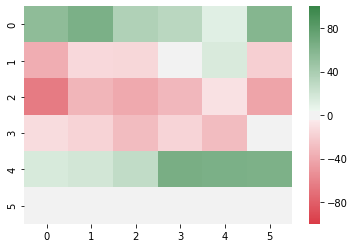

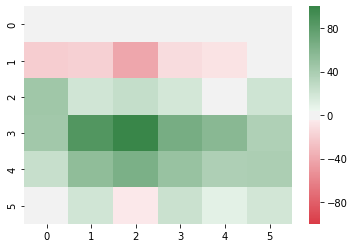

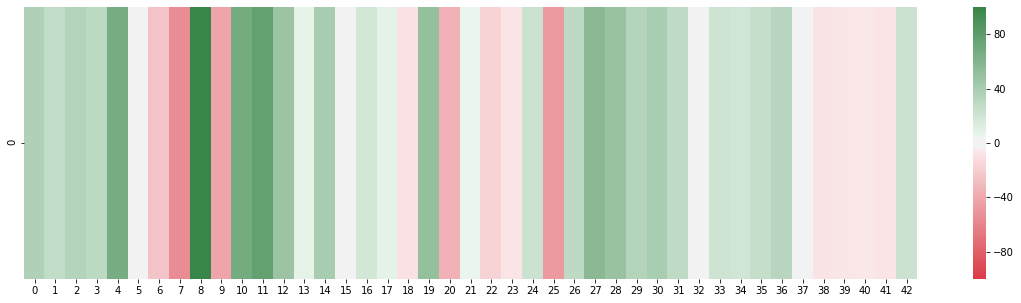

In [328]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(2*(N**2-N)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
ax.set_title('Presence of Piece in Each Board Position for Each Player')
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(2*(N**2-N), len(θ)):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

dataX = []
dataO = [np.array([0]*N)]
for i in range(0, N**2-N, N):
    dataX.append(θ[i:i+N])
dataX.append(np.array([0]*N))
    
for i in range(N**2-N, 2*(N**2-N), N):
    dataO.append(θ[i:i+N])
    
data = θ[2*(N**2-N):]
    
FACTOR = 100

cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(dataX, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()
sns.heatmap(dataO, cmap=cmap, vmin=-FACTOR, vmax=FACTOR)
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap([data], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax)